In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
import re
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\soyou\anaconda3\lib\site-packages\dask\dataframe\utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [2]:
# 데이터 불러오기

od = pd.read_csv("taxonomy_data.csv",encoding='cp949')
od

,샘플이름,성별,키(m),몸무게(kg),BMI,나이,d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__;__,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__[Eubacterium]_coprostanoligenes_group;g__[Eubacterium]_coprostanoligenes_group;s__metagenome,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Cytophagales;f__Hymenobacteraceae;g__Hymenobacter;__,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;__,...,d__Bacteria;p__Patescibacteria;c__Saccharimonadia;o__Saccharimonadales;f__LWQ8;g__LWQ8;s__uncultured_soil,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Beijerinckiaceae;g__uncultured;s__uncultured_soil,d__Bacteria;p__Acidobacteriota;c__Blastocatellia;o__Pyrinomonadales;f__Pyrinomonadaceae;g__RB41;s__uncultivated_soil,d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae;s__Christensenella_sp.,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Chitinophagaceae;g__Flavisolibacter;__,d__Bacteria;p__Bdellovibrionota;c__Oligoflexia;o__Silvanigrellales;f__Silvanigrellaceae;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_animalis,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__uncultured;s__unidentified,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__UCG-010;g__UCG-010;s__bacterium_enrichment,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinotignum;s__Actinotignum_schaalii
0,S0001,남,1.635,62.5,23.380000,57,0.022808,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S0002,남,1.575,62.4,25.154951,63,0.020138,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,S0003,여,1.556,55.9,23.088335,63,0.025701,0.000000,0.0,0.000111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S0004,여,1.667,67.3,24.218312,62,0.036104,0.002781,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S0005,여,1.610,59.9,23.108676,43,0.026647,0.000000,0.0,0.034101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,S1507,여,1.612,76.5,29.439563,44,0.022308,0.000000,0.0,0.044838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1507,S1508,남,1.753,79.8,25.968033,45,0.040610,0.002893,0.0,0.039497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1508,S1509,남,1.722,71.6,24.146085,53,0.040832,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1509,S1510,여,1.546,44.0,18.409148,29,0.015131,0.021139,0.0,0.031041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# 추가 데이터 불러오기
ad = pd.read_csv("additional_data.csv",encoding='cp949')
ad.columns = ['id', 'chao1', 'shannon']
ad.head()

,id,chao1,shannon
0,S0001,184.000000,5.694573
1,S0002,272.500000,6.018361
2,S0003,192.583333,5.667854
3,S0004,164.142857,5.783435
4,S0005,240.000000,5.635428


In [4]:
# 두 데이터 merge 하기
df = pd.merge(od, ad, left_on = "샘플이름", right_on = "id", how = "left")
df = df.drop(['id'], axis = 1)

In [5]:
# 성별에 있는 공백 제거하기
df['성별'] = df['성별'].str.strip()

## 남자 BMI 예측

In [7]:
df_male = df.loc[df['성별'] == '남']

In [13]:
dfX = df_male[df.columns.difference(['샘플이름','키(m)', '몸무게(kg)', 'BMI', '성별'])]
dfy = df_male['BMI']

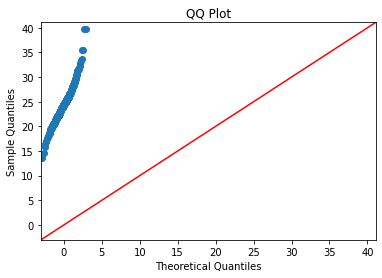

Shapiro-Wilk test p-value = 0.0000001023
KS test p-value = 0.0333819762


In [14]:
# Normality check

import statsmodels.api as sm
sm.qqplot(dfy, line="45")
plt.title('QQ Plot')
plt.show()

# Shapiro-Wilk test
stat, p = stats.shapiro(dfy)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = dfy.mean()
s = dfy.std()
stat, p = stats.kstest(dfy, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))

Box-Cox lambda for x1 : 0.22529906504199732
Shapiro-Wilk test p-value = 0.0000753218
KS test p-value = 0.2085449584


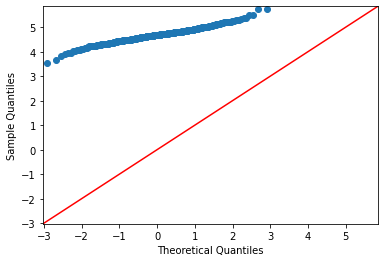

In [15]:
# Box-Cox Transformation

y  = np.array(dfy).reshape(-1)
y_most_normal, lmbda_optimal = stats.boxcox(y)
print("Box-Cox lambda for x1 : {}".format(lmbda_optimal))
#print("Transformed y by Box-Cox : {}".format(y_most_normal))

# qqplot
sm.qqplot(y_most_normal, line="45")

# Shapiro-Wilk test
stat, p = stats.shapiro(y_most_normal)
print("Shapiro-Wilk test p-value = %.10f" % (p))

# Kolmogorov-Smirnov test
m = y_most_normal.mean()
s = y_most_normal.std()
stat, p = stats.kstest(y_most_normal, 'norm', args = (m,s))
print("KS test p-value = %.10f" % (p))

## 값이 대부분 0인 predictors 제외하기

In [16]:
# 90% 이상이 zero value인 column list 만들기

column_list = dfX.columns.tolist()
zero_prop_list = []
for i in range(len(column_list)):
    zero_prop = len(dfX[column_list[i]].loc[dfX[column_list[i]] == 0]) / len(dfX)
    zero_prop_list.append(zero_prop)

df_prop = pd.DataFrame({"var" : column_list, "prop" : zero_prop_list})
zero_var_list = df_prop.loc[df_prop['prop'] >=0.9]['var'].tolist()

new_x_column_list = [element for element in column_list if element not in zero_var_list]

In [17]:
# 해당 컬럼 제외한 새로운 predictor data set 만들기 
dfX_new = dfX[new_x_column_list]
dfX_new.head()

,chao1,d__Bacteria;__;__;__;__;__;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_odontolytica,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Enterorhabdus;s__uncultured_bacterium,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Pasteurellaceae;g__Haemophilus;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas;__,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus_evryensis,d__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Cloacibacillus;s__Cloacibacillus_porcorum,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;__,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis,d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,shannon,나이
0,184.000000,0.000056,0.000000,0.004562,0.000000,0.0,0.000334,0.000223,0.000000,0.000000,...,0.040777,0.0,0.000000,0.000000,0.000223,0.000111,0.0,0.000000,5.694573,57
1,272.500000,0.000000,0.000167,0.000890,0.000000,0.0,0.000167,0.000000,0.000000,0.000000,...,0.003894,0.0,0.000000,0.000834,0.002559,0.000000,0.0,0.000000,6.018361,63
9,276.687500,0.000000,0.000000,0.000000,0.000000,0.0,0.000056,0.000278,0.000111,0.000056,...,0.011182,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.727141,66
13,153.142857,0.000223,0.000000,0.005897,0.003393,0.0,0.000000,0.007788,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.359636,33
15,199.217391,0.000389,0.000000,0.000000,0.000000,0.0,0.000000,0.000111,0.000000,0.000000,...,0.001391,0.0,0.000056,0.000000,0.000111,0.000000,0.0,0.000668,5.149559,58


## Interaction term 추가

In [18]:
# 위의 feature들로 interaction 추가해보기
from sklearn.preprocessing import PolynomialFeatures

# add interaction terms (x1*x2, but not x1**2) for all remaining features
create_interactions = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_poly = create_interactions.fit_transform(dfX_new)
X_poly = pd.DataFrame(X_poly,index=dfy.index)

In [19]:
# save info on which features contribute to each term in X_poly
powers = pd.DataFrame(create_interactions.powers_, columns = dfX_new.columns)
s = np.where(powers > 0, pd.Series(dfX_new.columns)+', ', '')
poly_terms = pd.Series([''.join(x).strip() for x in s])
X_poly.columns = poly_terms

## Interaction feature들이 누적 impotance가 90%이하인 feature만 선택하여 추가

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_most_normal, random_state=12)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)


def re_trans(y, lmbda_optimal):
    result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
    return result

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.585
Accuracy on Test set :-0.017
·MAE: 2.4859290841064072
·MSE: 11.449458854645167
·RMSE: 3.3837049006444353


In [21]:
feature_imp_poly = pd.DataFrame({'features' : X_poly.columns, 'values' : forest.feature_importances_})
feature_imp_poly = feature_imp_poly.sort_values(by = 'values', ascending = False).reset_index().drop(['index'],axis=1)
feature_imp_poly['cum_prop']= feature_imp_poly['values'].cumsum() / feature_imp_poly['values'].sum()

In [22]:
feature_imp_poly['cum_prop'].loc[feature_imp_poly['cum_prop']<=0.9]

0       0.002542
1       0.004589
2       0.006580
3       0.008512
4       0.010414
          ...   
2765    0.899594
2766    0.899689
2767    0.899784
2768    0.899878
2769    0.899973
Name: cum_prop, Length: 2770, dtype: float64

In [23]:
most_imp_features = feature_imp_poly['features'].tolist()[0:2770]
X_poly_selected = X_poly[most_imp_features]
X_poly_selected = X_poly_selected.reset_index().drop(['index'],axis = 1)

In [26]:
X_poly_selected.head()

,"d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;s__gut_metagenome, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Mitsuokella;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__uncultured;s__Prevotella_sp., d__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Butyricicoccaceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium_sensu_stricto_1;s__Clostridium_perfringens, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Incertae_Sedis;s__uncultured_organism,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_fragilis, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Marvinbryantia;s__uncultured_Clostridium,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes_obesi, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium_sensu_stricto_1;s__Clostridium_perfringens,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__uncultured;__, shannon,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Butyrivibrio;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae,",...,"d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus, shannon,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Butyricicoccaceae;g__Butyricicoccus;s__uncultured_bacterium, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__NK4A214_group;s__metagenome,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Leuconostoc;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Coprococcus;__,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia;s__Blautia_caecimuris,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-003;s__metagenome, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__uncultured;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__Oscillibacter;s__human_gut, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Faecalibacterium;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_coprocola, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Megamonas;__,","d__Bacteria;p__Desulfobacterota;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_eligens_group;__,","chao1, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Mitsuokella;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g_

## Interaction term을 PCA로 줄여서 넣어보기

In [27]:
from sklearn.preprocessing import StandardScaler  
x = X_poly.values 
y = dfy.values 
x = StandardScaler().fit_transform(x) 

features = X_poly.columns.tolist()
pd.DataFrame(x, columns=features).head()

,"chao1,","d__Bacteria;__;__;__;__;__;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__Schaalia_odontolytica,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;__,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_bifidum,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium;s__Bifidobacterium_dentium,","d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Micrococcales;f__Micrococcaceae;g__Rothia;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella;__,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Enterorhabdus;s__uncultured_bacterium,","d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Senegalimassilia;s__uncultured_bacterium,",...,"d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__Victivallaceae;g__Victivallis;s__Victivallis_vadensis, 나이,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Lentisphaeria;o__Victivallales;f__vadinBE97;g__vadinBE97;s__uncultured_rumen, 나이,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, shannon,","d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia;__, 나이,","shannon, 나이,"
0,-0.178374,-0.627196,-0.191595,-0.144367,-0.202735,-0.224757,0.674002,-0.369399,-0.255966,-0.318613,...,-0.096942,-0.122674,-0.035964,-0.070825,-0.083364,-0.244105,-0.227758,-0.170272,-0.188469,0.457397
1,1.083106,-0.683936,1.498864,-0.339922,-0.202735,-0.224757,0.264209,-0.388629,-0.255966,-0.318613,...,-0.096942,-0.122674,-0.261002,-0.265704,-0.083364,-0.244105,-0.227758,-0.170272,-0.188469,0.911270
2,1.142795,-0.683936,-0.191595,-0.387329,-0.202735,-0.224757,-0.009059,-0.364592,0.920646,-0.190908,...,-0.096942,-0.122674,-0.261002,-0.265704,-0.083364,-0.244105,-0.227758,-0.170272,-0.188469,0.901576
3,-0.618212,-0.456856,-0.191595,-0.073256,5.257042,-0.224757,-0.145584,0.284412,-0.255966,-0.318613,...,-0.096942,-0.122674,-0.261002,-0.265704,-0.083364,-0.244105,-0.227758,-0.170272,-0.188469,-0.771337
4,0.038535,-0.286547,-0.191595,-0.387329,-0.202735,-0.224757,-0.145584,-0.379014,-0.255966,-0.318613,...,-0.096942,-0.122674,-0.261002,-0.265704,-0.083364,-0.244105,-0.227758,-0.133614,-0.133472,0.241830


In [28]:
from sklearn.decomposition import PCA
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(x)
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
print('X_pca shape', X_pca.shape)
X_pca.head()

X_pca shape (547, 547)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC538,PC539,PC540,PC541,PC542,PC543,PC544,PC545,PC546,PC547
0,-9.896273,-23.580182,8.589942,-1.989055,-17.022018,-3.072671,-4.700672,-9.003403,0.769629,-13.362517,...,0.120802,-0.010587,0.068620,0.007427,-0.121841,-0.008727,-0.053469,-0.018158,0.005556,4.877243e-14
1,42.841998,-29.374919,32.807277,24.680290,-25.840782,-25.585877,2.397975,-5.246075,-7.592963,-31.023138,...,-0.032511,0.018317,0.030999,-0.002523,-0.044216,0.010936,-0.010282,0.000694,0.013449,4.877243e-14
2,2.159643,-29.291710,13.704732,5.026718,-10.149049,-2.477293,1.909144,0.412368,3.471884,-9.285018,...,-0.107133,-0.092127,0.067048,-0.086116,0.061742,-0.011738,0.051658,-0.040736,-0.031879,4.877243e-14
3,-19.032332,64.135825,-36.422904,38.463761,47.186124,29.345860,28.606461,89.589579,11.176596,-18.201167,...,-0.012794,-0.000383,-0.007021,-0.045962,-0.004316,-0.048021,0.031368,0.032295,-0.001167,4.877243e-14
4,0.153939,-20.476625,-10.157161,-13.370803,-11.296037,-7.101935,1.113860,-18.011403,13.170746,2.153489,...,0.213192,-0.083036,-0.005785,-0.035330,-0.073126,0.029743,-0.052512,-0.060355,0.002645,4.877243e-14


In [30]:
X_pca_inter = X_pca.iloc[:,0:50]
X_pca_inter
dfX_pca = pd.concat([X_poly_selected, X_pca_inter], axis = 1)
dfX_pca.head()

,"d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-005;s__gut_metagenome, d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Selenomonadaceae;g__Mitsuokella;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__uncultured;s__Prevotella_sp., d__Bacteria;p__Firmicutes;c__Clostridia;o__Monoglobales;f__Monoglobaceae;g__Monoglobus;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Butyricicoccaceae;__;__,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium_sensu_stricto_1;s__Clostridium_perfringens, d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Incertae_Sedis;s__uncultured_organism,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_fragilis, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Marvinbryantia;s__uncultured_Clostridium,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__Alistipes;s__Alistipes_obesi, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Ruminococcus]_torques_group;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium_sensu_stricto_1;s__Clostridium_perfringens,","d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__uncultured;__, shannon,","d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Butyrivibrio;__,","d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Paraprevotella;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ventriosum_group;s__uncultured_Lachnospiraceae,",...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,0.0,0.0,0.0,0.000000,0.0,1.114078e-07,0.0,0.0,0.0,0.000000e+00,...,-5.506758,-0.786089,-4.172728,-4.738077,11.837254,-3.569670,-0.709309,3.966529,5.036667,4.575125
1,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,...,-49.350432,-25.001876,-91.627395,-18.484953,28.809579,-40.788214,31.284727,61.470600,11.738149,6.328758
2,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,7.427172e-08,...,11.274870,0.957937,-8.859143,0.434281,3.728071,-7.770091,-1.561272,2.181148,2.988827,-4.021369
3,0.0,0.0,0.0,0.000001,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,...,-20.846790,-106.212044,5.767135,-50.072554,15.014926,6.197373,-52.188607,1.977829,-54.969195,23.271254
4,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,1.627788e-06,...,-2.383272,1.396917,6.028251,-3.227831,-5.007632,-4.733958,-0.332985,6.304031,-8.322344,1.723614


## Best train-test split

In [31]:
def rf_model(X_train, y_train, X_test, y_test):
    # random forest

    forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    forest.fit(X_train, y_train)

    #print("="*50)
    #print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
    #print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
    #print("="*50)


    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_pred = forest.predict(X_test)
    y_test_b = re_trans(y_test, lmbda_optimal)
    y_pred_b = re_trans(y_pred, lmbda_optimal)

    # MAE, MSE, RMSE
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    #print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
    #print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
    #print("="*50)
    MAE = mean_absolute_error(y_test_b, y_pred_b)
    
    return MAE
    

In [32]:
mae_list = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state=i)
    mae = rf_model(X_train, y_train, X_test, y_test)
    mae_list.append(mae)

In [33]:
pd.DataFrame({'mae' : mae_list}).sort_values(by='mae')

,mae
93,2.115264
31,2.124816
47,2.174760
59,2.179653
21,2.179840
...,...
48,2.675570
95,2.688376
9,2.700985
45,2.815213


In [53]:
# Best_train_test_set_split : random_state = 93

X_train, X_test, y_train, y_test = train_test_split(dfX_pca, y_most_normal, random_state = 93)

forest = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
forest.fit(X_train, y_train)

print("="*50)
print("Accuracy on Training set :{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on Test set :{:.3f}".format(forest.score(X_test, y_test)))
print("="*50)

y_pred = forest.predict(X_test)
y_test_b = re_trans(y_test, lmbda_optimal)
y_pred_b = re_trans(y_pred, lmbda_optimal)

# MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("·MAE:",mean_absolute_error(y_test_b, y_pred_b))
print("·MSE:", mean_squared_error(y_test_b, y_pred_b))
print("·RMSE:", np.sqrt(mean_squared_error(y_test_b, y_pred_b)))
print("="*50)

Accuracy on Training set :0.679
Accuracy on Test set :0.006
·MAE: 2.115264088098527
·MSE: 8.045812563422881
·RMSE: 2.83651415709897


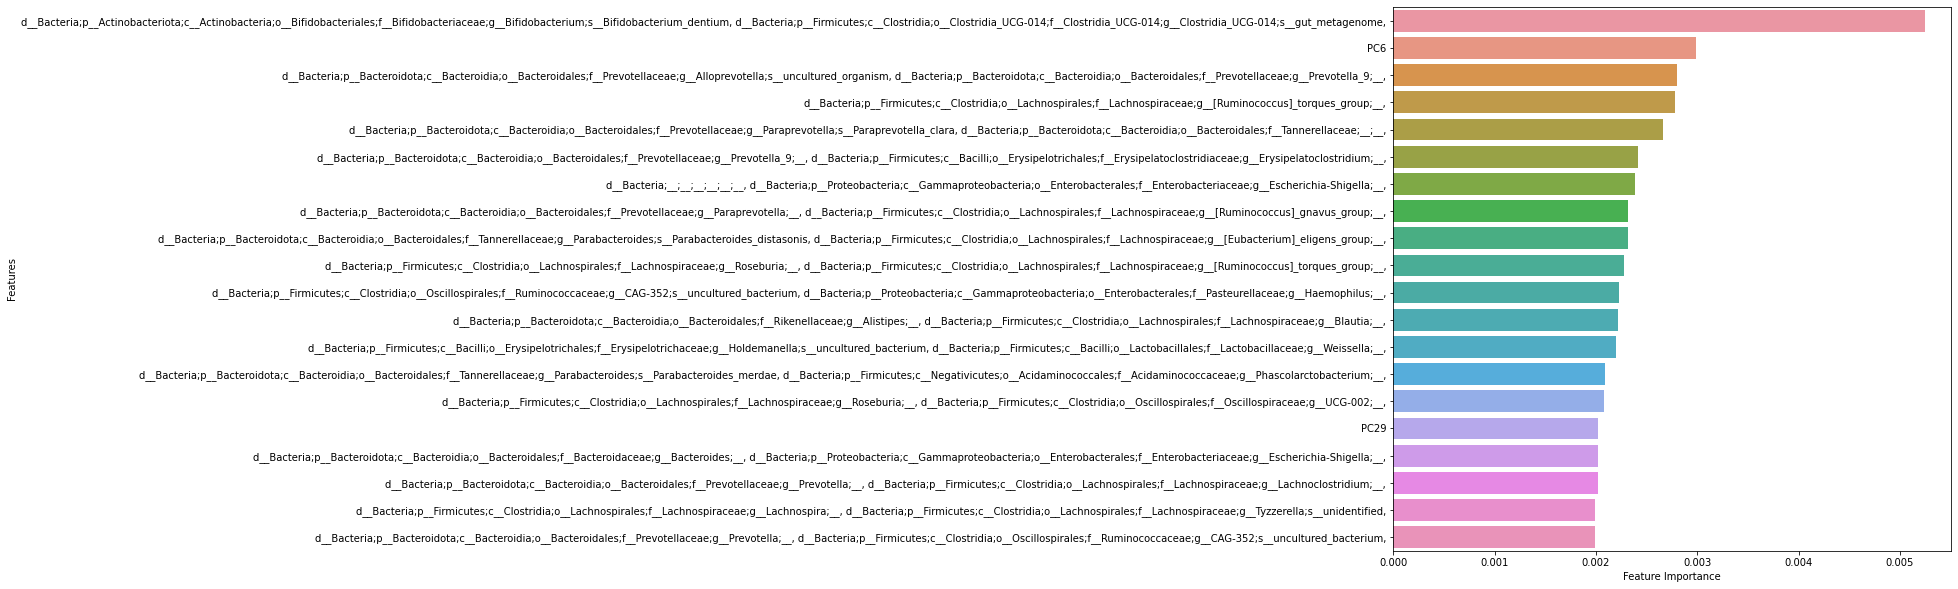

In [59]:
# Model Feature importance

feature_imp = pd.DataFrame({'Features' : forest.feature_names_in_, 'Feature Importance' : forest.feature_importances_})
feature_imp = feature_imp.sort_values(by = 'Feature Importance', ascending = False).reset_index(drop = True)

plt.figure(figsize= (10,10))
sns.barplot(x = 'Feature Importance', y = 'Features', data = feature_imp[0:20])
plt.show()

### SHAP Importance

In [55]:
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


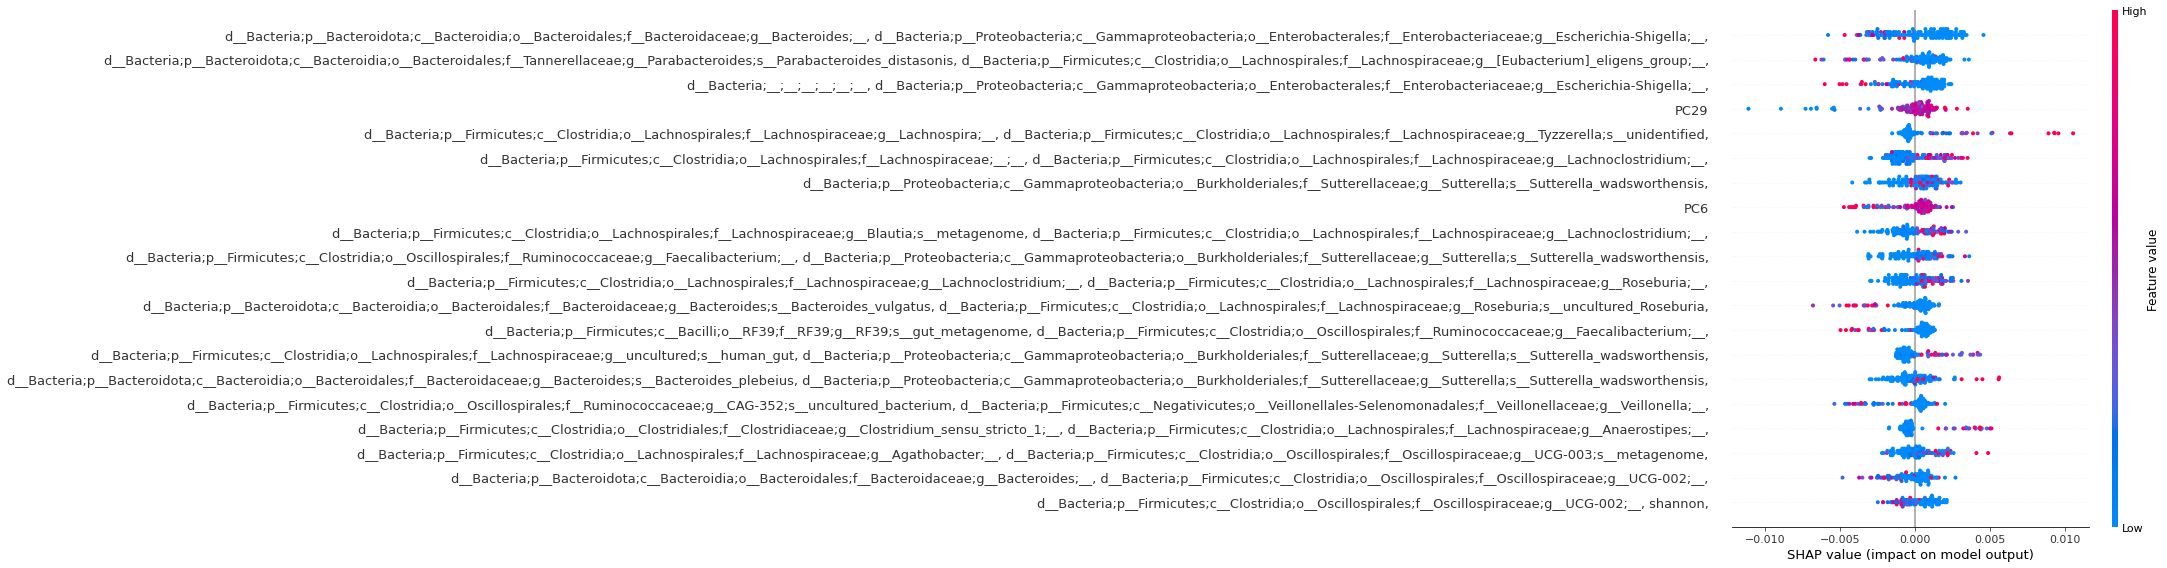

In [56]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

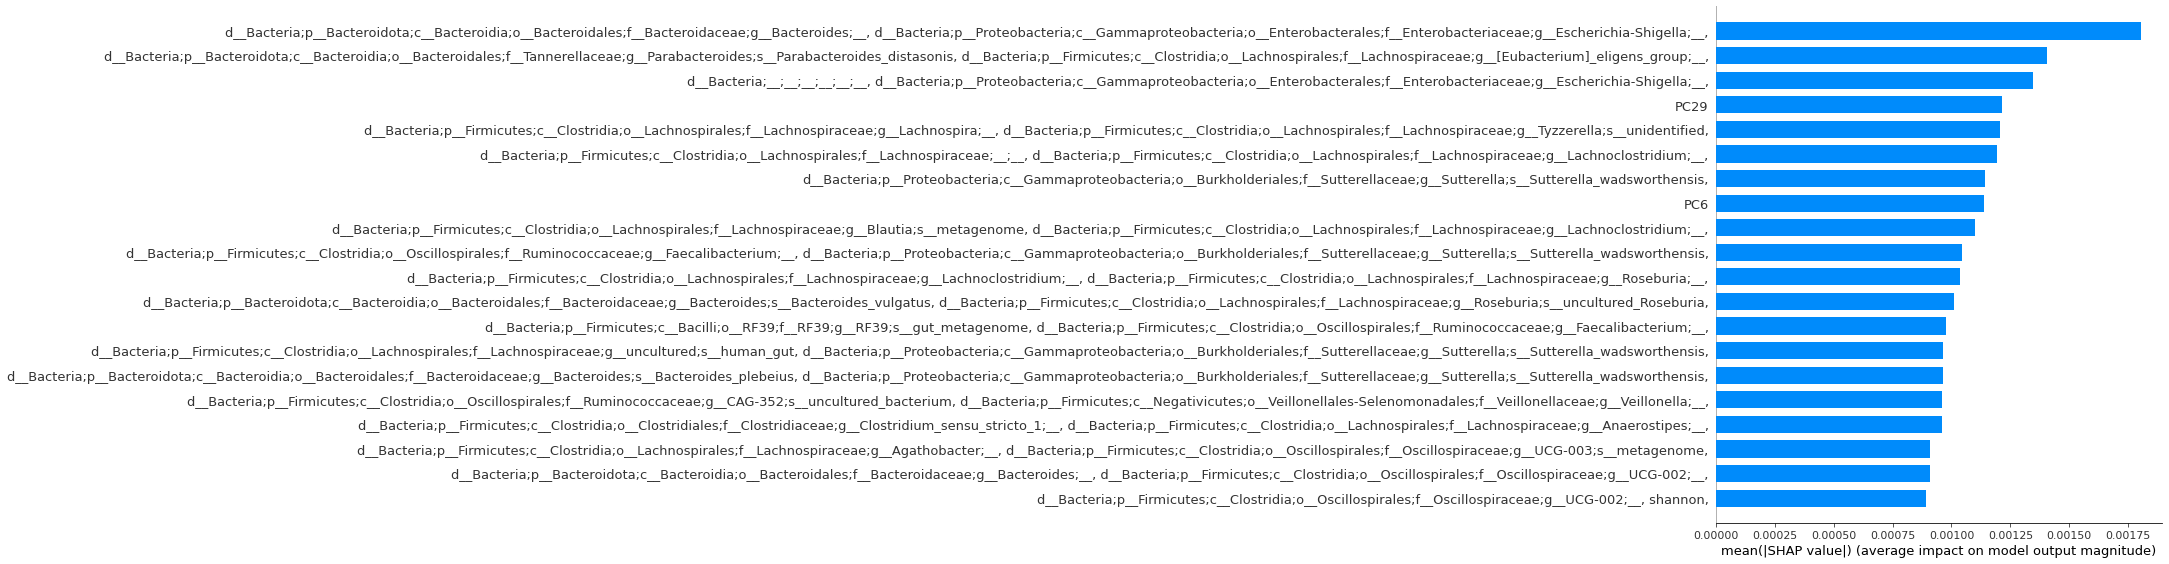

In [57]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [58]:
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)

# Model feature importance와 Shap importance 중 겹치는 것. 

set(feature_imp['Features'][0:20].tolist()) & set(importance_df['column_name'][0:20].tolist())

{'PC29',
 'PC6',
 'd__Bacteria;__;__;__;__;__;__, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella;__,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;__, d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia-Shigella;__,',
 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides;s__Parabacteroides_distasonis, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_eligens_group;__,',
 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Lachnospira;__, d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Tyzzerella;s__unidentified,'}

In [35]:
# xgboost

def xgbmodel(dfX, dfy, random_state):
    
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy, random_state=random_state)

    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
    X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

    xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state =0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    #feature_importance = xgb_model.feature_importances_

    #Print("="*50)
    #print('·train score:',xgb_model.score(X_train, y_train))
    #print('·validation score:',xgb_model.score(X_test, y_test))

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE

In [36]:
mae_list_xgb = []
for i in range(100):
    mae = xgbmodel(dfX_pca, y_most_normal, i)
    mae_list_xgb.append(mae)

In [37]:
pd.DataFrame({'mae' : mae_list_xgb}).sort_values(by='mae')

,mae
31,2.247127
93,2.297465
44,2.303468
63,2.384665
61,2.392764
...,...
34,2.977891
19,2.978543
90,3.059147
12,3.088920


In [45]:
component_names = [f"feature{i+1}" for i in range(dfX_pca.shape[1])]
dfX_pca_lgb = dfX_pca.copy()
dfX_pca_lgb.columns = component_names
dfX_pca_lgb.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature2811,feature2812,feature2813,feature2814,feature2815,feature2816,feature2817,feature2818,feature2819,feature2820
0,0.0,0.0,0.0,0.000000,0.0,1.114078e-07,0.0,0.0,0.0,0.000000e+00,...,-5.506758,-0.786089,-4.172728,-4.738077,11.837254,-3.569670,-0.709309,3.966529,5.036667,4.575125
1,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,...,-49.350432,-25.001876,-91.627395,-18.484953,28.809579,-40.788214,31.284727,61.470600,11.738149,6.328758
2,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,7.427172e-08,...,11.274870,0.957937,-8.859143,0.434281,3.728071,-7.770091,-1.561272,2.181148,2.988827,-4.021369
3,0.0,0.0,0.0,0.000001,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,...,-20.846790,-106.212044,5.767135,-50.072554,15.014926,6.197373,-52.188607,1.977829,-54.969195,23.271254
4,0.0,0.0,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,1.627788e-06,...,-2.383272,1.396917,6.028251,-3.227831,-5.007632,-4.733958,-0.332985,6.304031,-8.322344,1.723614


In [46]:
# lightgbm

def lightgbm_model(dfX, dfy, random_state):
    
    dfX = dfX.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    X_train, X_test, y_train, y_test = train_test_split(dfX, dfy ,random_state = random_state)

    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #print('='*50)
    #print("Best model train set score : {}".format(model.score(X_train, y_train)))
    #print("Best model test set score : {}".format(model.score(X_test, y_test)))
    #print('='*50)

    # Box-cox transformation 역변환
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result

    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(y_pred, lmbda_optimal)

    #print("·MAE:", mean_absolute_error(y_test, y_pred))
    #print("·MSE:", mean_squared_error(y_test, y_pred))
    #print("·RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    #print("="*50)
    
    MAE = mean_absolute_error(y_test, y_pred)
    return MAE
    

In [47]:
mae_list_lgb = []
for i in range(100):
    mae = lightgbm_model(dfX_pca_lgb, y_most_normal, i)
    mae_list_lgb.append(mae)

In [48]:
pd.DataFrame({'mae' : mae_list_lgb}).sort_values(by='mae')

,mae
33,2.229481
93,2.242690
59,2.257851
44,2.263476
31,2.302991
...,...
90,2.764258
34,2.862733
45,2.871205
35,2.879167


## K-fold cross validation

In [49]:
from sklearn.model_selection import KFold

In [50]:
# Random Forest

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

test_mae_total_rf = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(max_depth = 11, max_features = "log2", random_state = 2)
    model.fit(X_train, y_train)
    
    #train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total_rf.append(test_mae)

print(test_mae_total_rf)
print(np.mean(test_mae_total_rf))


[2.4364022937891296, 2.1618891703459315, 2.4185512960930278, 2.423377732942826, 2.566782524254371]
2.4014006034850572


In [51]:
# xgboost

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca.copy()
y = y_most_normal.copy()

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

print(test_mae_total)
print(np.mean(test_mae_total))

[2.544273415065606, 2.5132376681651274, 2.7085443408075003, 2.587301616448045, 2.8987147395834367]
2.650414356013943


In [52]:
# lightgbm

kf = KFold(n_splits = 5, shuffle= True)

X = dfX_pca_lgb.copy()
y = y_most_normal.copy()

X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_mae_total = []
test_mae_total = []
for train_index, test_index in kf.split(X):
    # X_train, X_test 정의
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = lgb.LGBMRegressor(random_state = 0)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train) # 훈련셋 예측
    test_pred = model.predict(X_test) # 시험셋 예측
    
    def re_trans(y, lmbda_optimal):
        result = (y*lmbda_optimal + 1)**(1/lmbda_optimal)
        return result
    
    y_test = re_trans(y_test, lmbda_optimal)
    y_pred = re_trans(test_pred, lmbda_optimal)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_mae_total.append(test_mae)

print(test_mae_total)
print(np.mean(test_mae_total))

[2.5323685008546506, 2.6985128458322456, 2.388537097292836, 2.5875618272037615, 2.6412741420862322]
2.569650882653945
